In [192]:
#API
from flask import Flask, jsonify
from flask import request
from flasgger import Swagger, LazyString, LazyJSONEncoder
from flasgger import swag_from

#Cleansing
import re 
import pandas as pd
import numpy as np
import demoji
import pickle

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Stemmer
from pathlib import Path
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords

#Extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

#NLTK
nltk.download('stopwords')
nltk.download('punkt')

#CallFile
stop_words = set(stopwords.words('indonesian'))
factory = StemmerFactory()
stemmer = factory.create_stemmer()

id_stopword_dict = pd.read_csv('stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

df_kbbi = pd.read_csv('new_kamusalay.csv', header=None, encoding='ISO-8859-1', names=['TIDAKBAKU', 'BAKU'])

#defination of data test, train, and validation
df_train = pd.read_csv("train_preprocess.txt", delimiter = "\t", header=None)
df_valid = pd.read_csv("train_preprocess.txt", delimiter = "\t", header=None)
df_test = pd.read_csv("train_preprocess.txt", delimiter = "\t", header=None)
df = df_train._append(df_valid, ignore_index=True)

df.columns =['text', 'label']
sentiment = ['negative', 'neutral', 'positive']

from collections import Counter
from wordcloud import WordCloud
import string

df_kbbi = pd.read_csv('KamusAlayIvan.csv', header=None, encoding='ISO-8859-1', names=['TIDAKBAKU', 'BAKU'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hivan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [193]:

def removechars(text):
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))','',text)
    text = re.sub('\d', '', text)
    text = re.sub(r'\b\w\b', '', text)
    text = re.sub('di','',text) 
    text = re.sub('yang','',text) 
    text = re.sub('dan','',text) 
    text = re.sub('nya','',text) 
    text = re.sub('saya','',text)
    text = re.sub('ini','',text)
    text = re.sub('itu','',text)
    text = re.sub('aku','',text)
    text = re.sub('kamu','',text)
    text = re.sub('th','',text)
    return text

def changealay(text):
    alay = dict(zip(df_kbbi['TIDAKBAKU'], df_kbbi['BAKU']))
    text = ' '.join([alay[word] if word in alay else word for word in text.split(' ')])
    return text

In [194]:
def cleaning(text):
    text = removechars(text)
    text = changealay(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [195]:
df = pd.read_csv("train_preprocess.txt", delimiter = "\t", header=None)
df.columns =['text', 'label']
sentiment = ['negative', 'neutral', 'positive']

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [197]:
df['text'] = df['text'].apply(cleaning)

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [199]:
count_vect = CountVectorizer()
count_vect.fit(df['text'])

x = count_vect.transform(df['text'])
print ('Feature Extraction selesai')

Feature Extraction selesai


In [200]:
df['tokens'] = df['text'].str.split()


In [201]:
# Menggabungkan semua token berdasarkan label
positive_words = df[df['label'] == 'positive']['tokens'].sum()
negative_words = df[df['label'] == 'negative']['tokens'].sum()
neutral_words = df[df['label'] == 'neutral']['tokens'].sum()

In [202]:
# Hitung frekuensi kata untuk setiap label
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)
neutral_word_counts = Counter(neutral_words)

In [203]:
# Buat DataFrame untuk visualisasi
positive_df = pd.DataFrame(positive_word_counts.items(), columns=['word', 'count'])
negative_df = pd.DataFrame(negative_word_counts.items(), columns=['word', 'count'])
neutral_df = pd.DataFrame(neutral_word_counts.items(), columns=['word', 'count'])

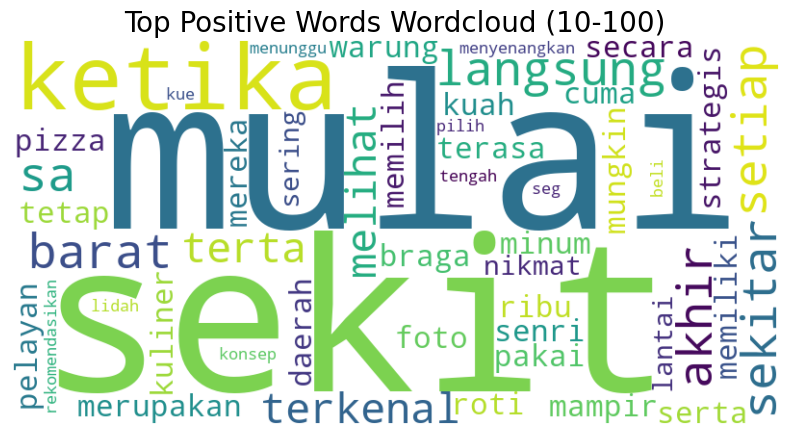

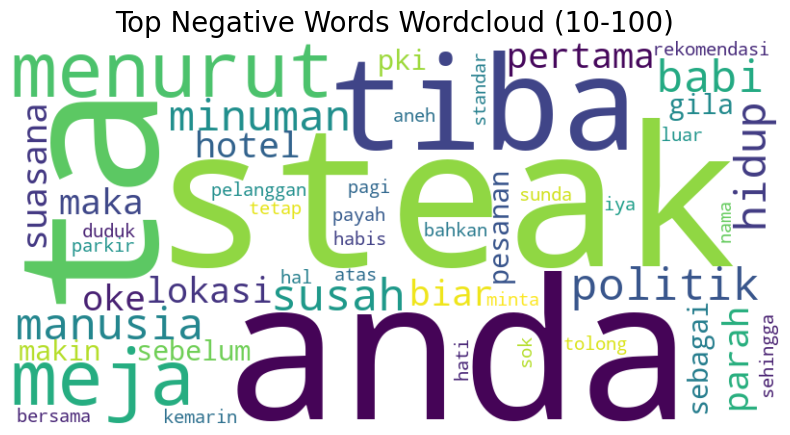

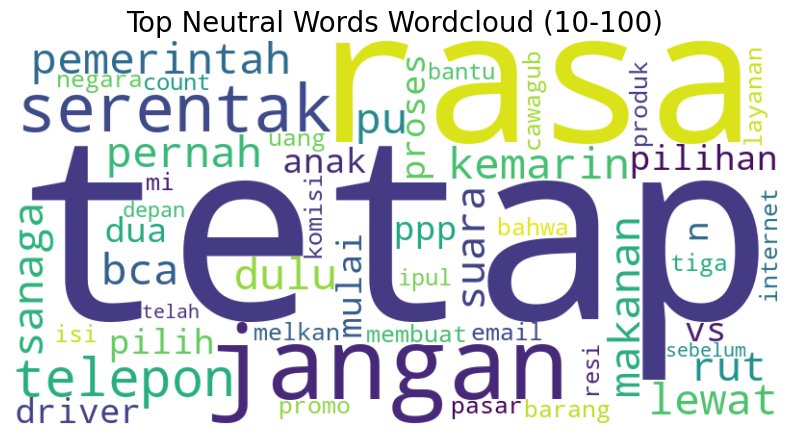

In [204]:
def plot_top_range_wordcloud(data, title, start=200, end=250):
    range_words = data.nlargest(end, 'count').iloc[start:end]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(range_words.values))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Plot word cloud untuk kata dalam rentang frekuensi tertentu (top range)
plot_top_range_wordcloud(positive_df, 'Top Positive Words Wordcloud (10-100)',start=200, end=250)
plot_top_range_wordcloud(negative_df, 'Top Negative Words Wordcloud (10-100)',start=200, end=250)
plot_top_range_wordcloud(neutral_df, 'Top Neutral Words Wordcloud (10-100)',start=200, end=250)

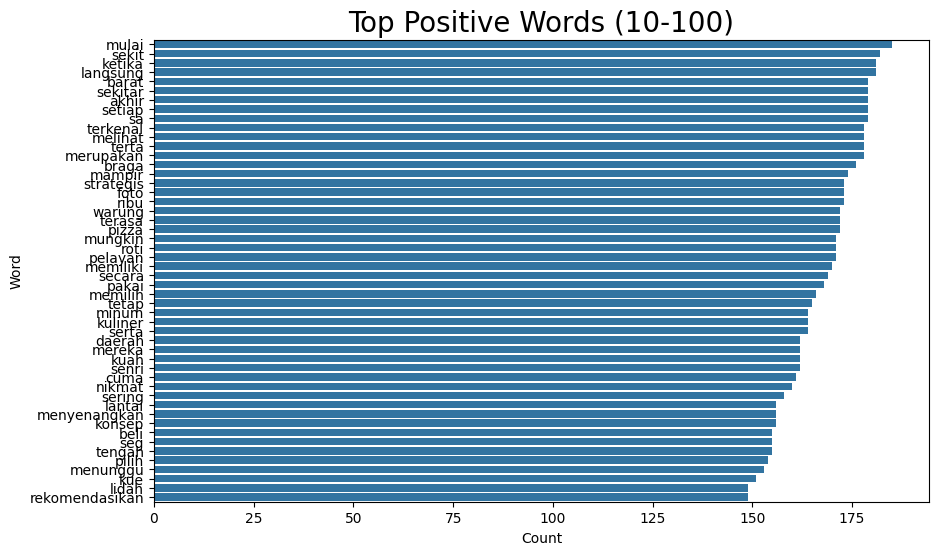

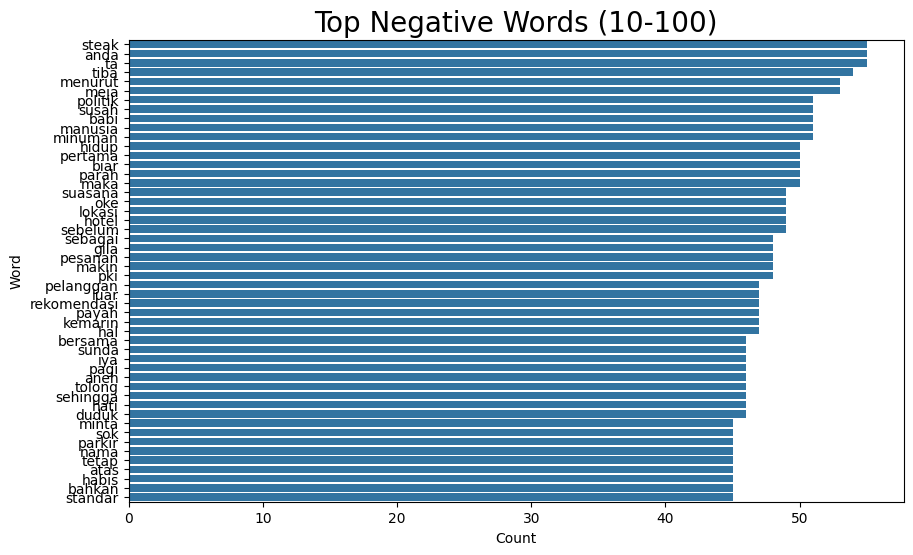

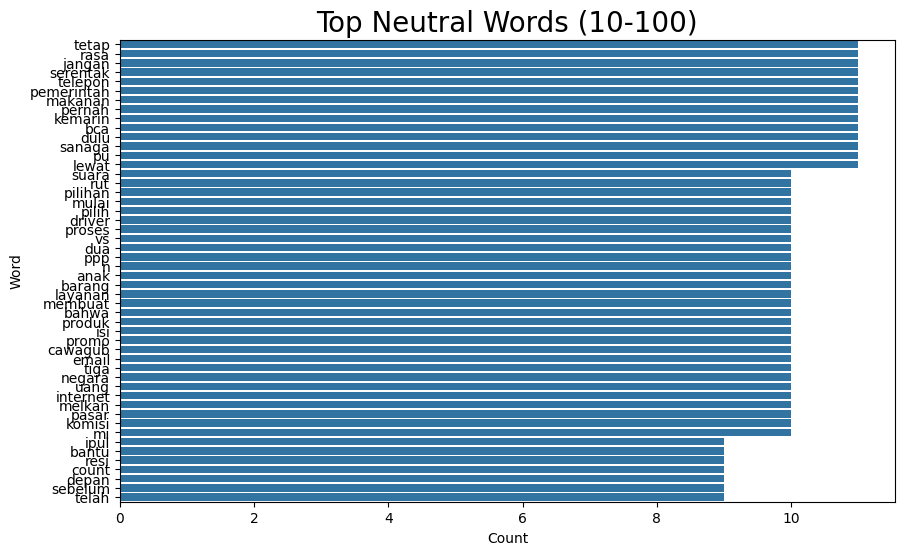

In [205]:
def plot_top_range_words(data, title, start=200, end=250):
    range_words = data.nlargest(end, 'count').iloc[start:end]
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=range_words)
    plt.title(title, fontsize=20)
    plt.xlabel('Count')
    plt.ylabel('Word')
    plt.show()

# Plot kata dalam rentang frekuensi tertentu untuk setiap label (bar chart)
plot_top_range_words(positive_df, 'Top Positive Words (10-100)',start=200, end=250)
plot_top_range_words(negative_df, 'Top Negative Words (10-100)',start=200, end=250)
plot_top_range_words(neutral_df, 'Top Neutral Words (10-100)',start=200, end=250)

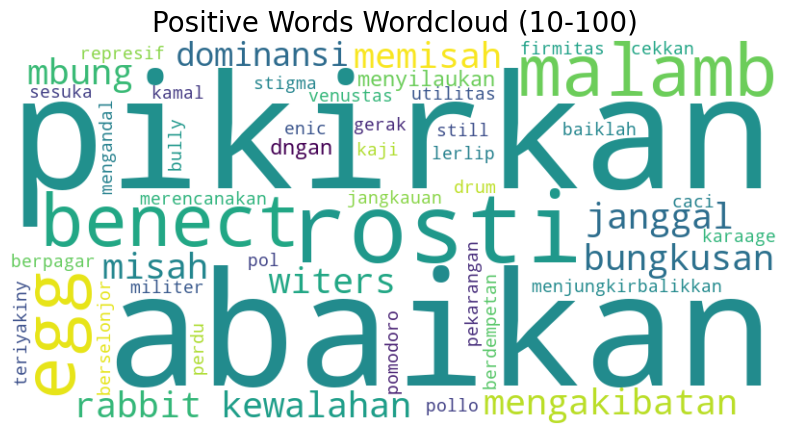

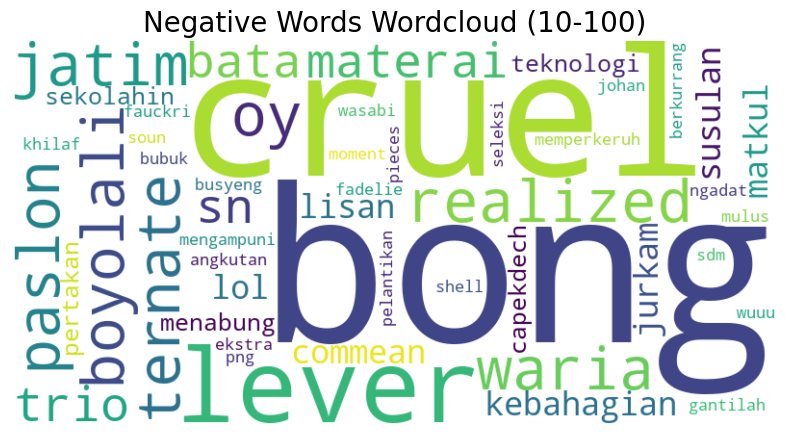

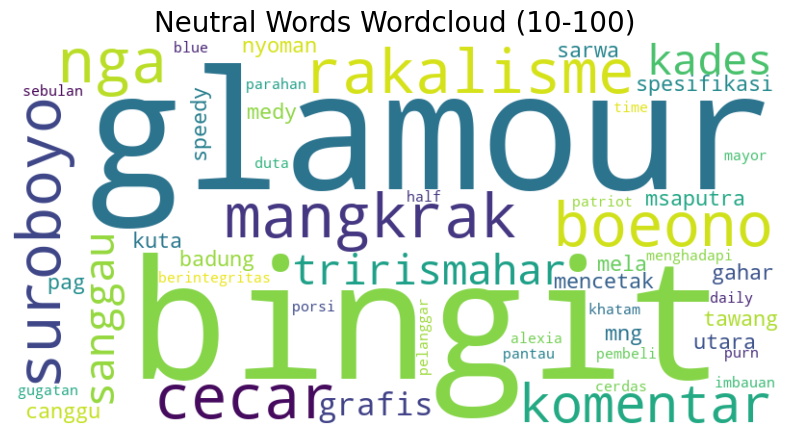

In [206]:
def plot_range_wordcloud(data, title, start=200, end=250):
    range_words = data.nsmallest(end, 'count').iloc[start:end]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(range_words.values))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

plot_range_wordcloud(positive_df, 'Positive Words Wordcloud (10-100)',start=200, end=250)
plot_range_wordcloud(negative_df, 'Negative Words Wordcloud (10-100)',start=200, end=250)
plot_range_wordcloud(neutral_df, 'Neutral Words Wordcloud (10-100)',start=200, end=250)

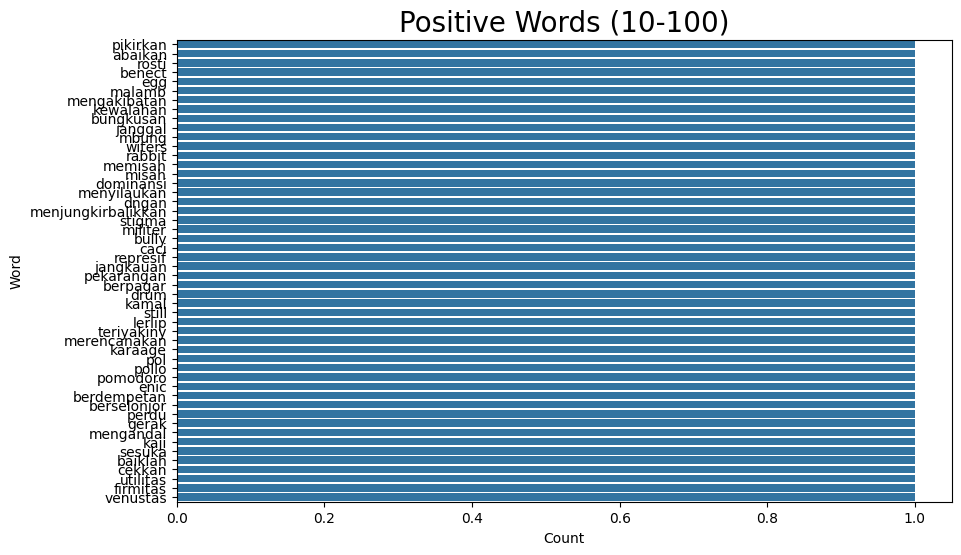

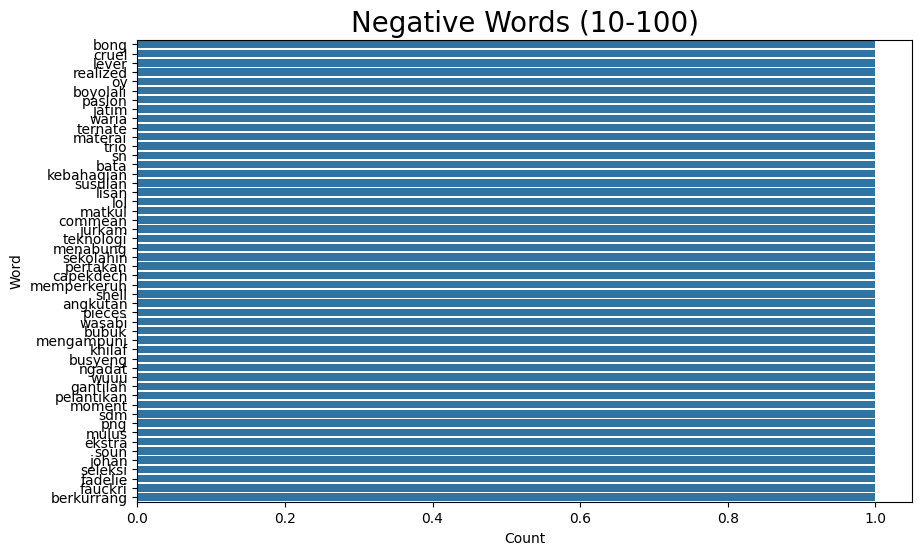

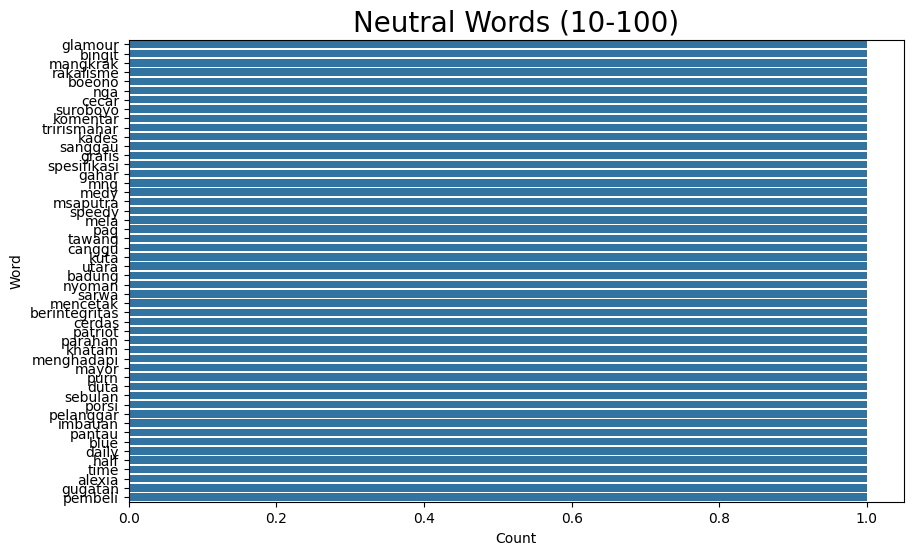

In [207]:
def plot_range_words(data, title, start=200, end=250):
    range_words = data.nsmallest(end, 'count').iloc[start:end]
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=range_words)
    plt.title(title, fontsize=20)
    plt.xlabel('Count')
    plt.ylabel('Word')
    plt.show()

# Plot kata dalam rentang frekuensi tertentu untuk setiap label
plot_range_words(positive_df, 'Positive Words (10-100)', start=200, end=250)
plot_range_words(negative_df, 'Negative Words (10-100)', start=200, end=250)
plot_range_words(neutral_df, 'Neutral Words (10-100)', start=200, end=250)